# Setup

## Imports

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../src/')
from preprocessing import (
    filter_low_magnitude_genes,
    filter_high_mito_cells,
    filter_high_apoptosis_cells,
    filter_high_rrna_cells,
    normalize_by_library_size,
    log_transform,
    genes
)
from visualization import plot_filtering_effect

## Data Loading

In [2]:
from data_loading import load_10x_data

DATA_PATH = '../data/'
raw_data = load_10x_data(DATA_PATH)

raw_data.shape

(5000, 33538)

# Gene Filtering

In [3]:
clean_data = filter_low_magnitude_genes(raw_data)

clean_data.shape

[Filter Magnitude] Dropped 19026 genes with max count < 2 (only 0s and 1s).


(5000, 14512)

# Quality Control (Cell Filtering)

## Mitochondrial

In [4]:
# Check if any start with "MT-"
print("'MT-' genes:", clean_data.columns.str.startswith('MT-').sum())

# Check if any start with "mt-" (Mouse)
print("'mt-' genes:", clean_data.columns.str.startswith('mt-').sum())

'MT-' genes: 13
'mt-' genes: 0


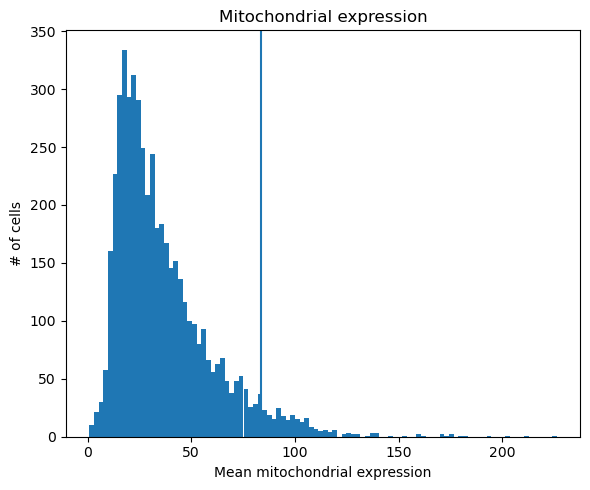

In [5]:
# get mitochondrial genes
mitochondrial_gene_list = np.array([g.startswith('MT-') for g in clean_data.columns])

# get expression
mito_exp = clean_data.loc[:,mitochondrial_gene_list].mean(axis=1)

# plotting
fig, ax = plt.subplots(1, figsize=(6,5))

ax.hist(mito_exp, bins=100)
cutoff_value = float(np.percentile(mito_exp, 95))
ax.axvline(cutoff_value)
ax.set_xlabel('Mean mitochondrial expression')
ax.set_ylabel('# of cells')
ax.set_title('Mitochondrial expression')

fig.tight_layout()

In [6]:
data_mito_filtered = filter_high_mito_cells(clean_data)

data_mito_filtered.shape

[Filter Mito] Starting mitochondrial gene removal...
Cutoff: 0.0998 (Ratio)
Dropped 250 cells (Top 5% expression).


(4750, 14512)

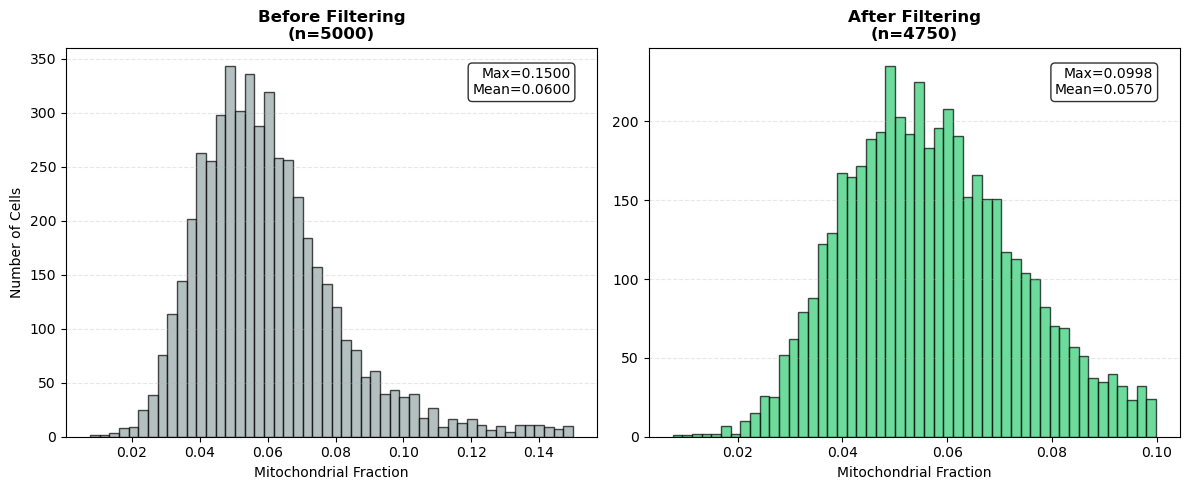

In [7]:
mito_genes = [col for col in clean_data.columns if col.startswith('MT-')]

plot_filtering_effect(
    data_before=clean_data,
    data_after=data_mito_filtered,
    gene_list=mito_genes,
    metric_name="Mitochondrial Fraction"
)

## Apoptosis

In [8]:
# Convert the list of apoptosis genes to a pandas Index for easy intersection
apoptosis_gene_index = pd.Index(genes.APOPTOSIS_GENES)

# This creates a new Index containing ONLY the common gene names.
overlapping_genes = raw_data.columns.intersection(apoptosis_gene_index)

# Use the list of overlapping genes to select only those columns from the data
apoptosis_data = raw_data[overlapping_genes]

print(f"Total genes in the 10X dataset: {len(raw_data.columns)}")
print(f"Total genes in the APOPTOSIS_GENES list: {len(genes.APOPTOSIS_GENES)}")
print("-" * 40)
print(f"Number of apoptosis genes found in the data: {len(overlapping_genes)}")

Total genes in the 10X dataset: 33538
Total genes in the APOPTOSIS_GENES list: 161
----------------------------------------
Number of apoptosis genes found in the data: 159


In [9]:
data_apoptosis_filtered = filter_high_apoptosis_cells(data_mito_filtered)

data_apoptosis_filtered.shape

[Filter Apoptosis] Starting apoptosis gene removal...
Cutoff: 0.0273 (Ratio)
Dropped 238 cells (Top 5% expression).


(4512, 14512)

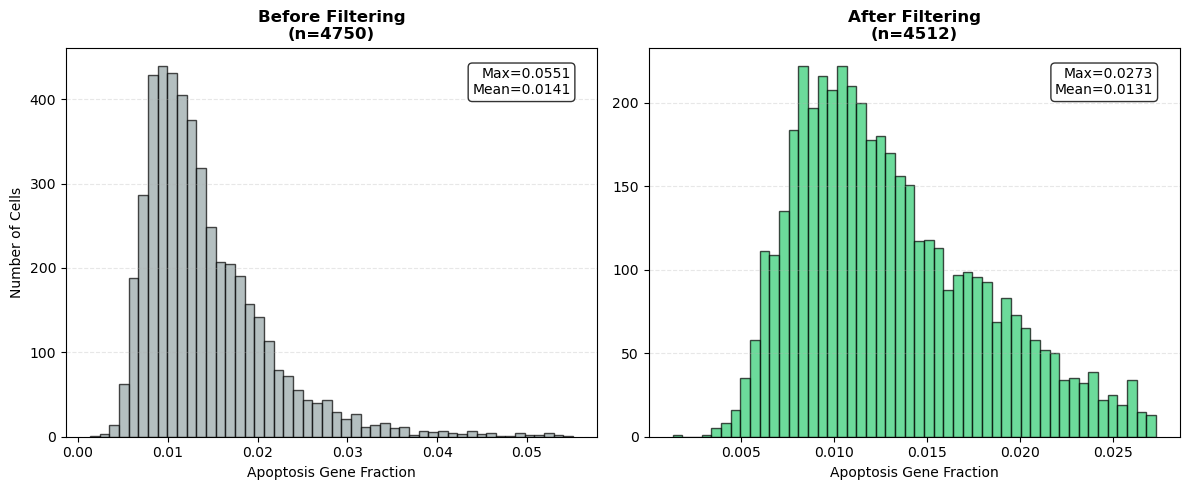

In [10]:
plot_filtering_effect(
    data_before=data_mito_filtered,
    data_after=data_apoptosis_filtered,
    gene_list=genes.APOPTOSIS_GENES,
    metric_name="Apoptosis Gene Fraction"
)

## rRNA

In [11]:
data_rrna_filtered = filter_high_rrna_cells(data_apoptosis_filtered)

data_rrna_filtered.shape

[Filter rRNA] Starting rRNA gene removal...
Cutoff: 0.4905 (Ratio)
Dropped 226 cells (Top 5% expression).


(4286, 14512)

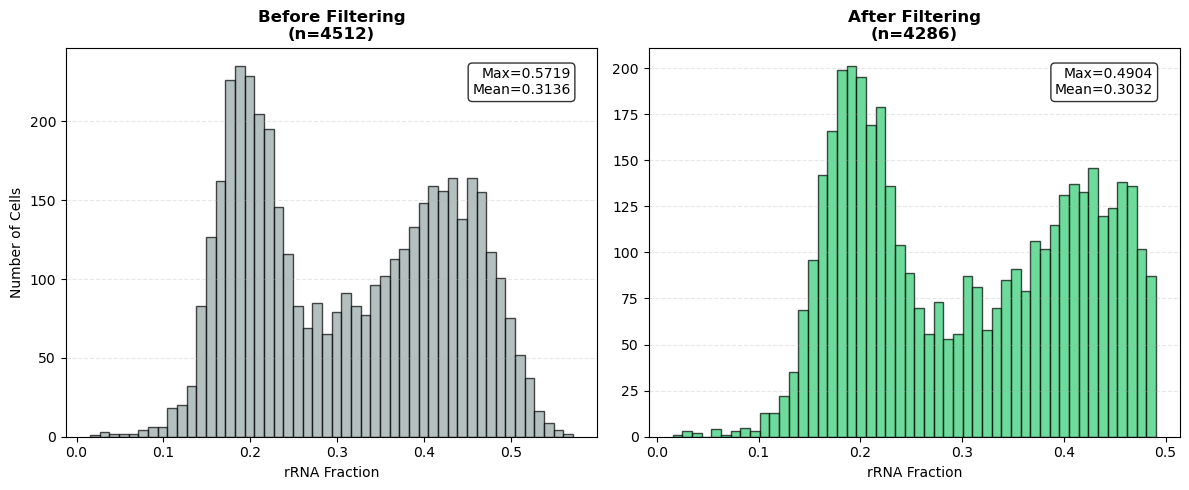

In [13]:
plot_filtering_effect(
    data_before=data_apoptosis_filtered,
    data_after=data_rrna_filtered,
    gene_list=genes.RRNA_GENES,
    metric_name="rRNA Fraction"
)

# Normalization & Transformation

In [12]:
normalized_data = normalize_by_library_size(data_rrna_filtered)

normalized_data.shape

[Normalize]   Normalizing library size (CPM) with rescale=1e+06...


(4286, 14512)

In [13]:
logged_data = log_transform(normalized_data)

logged_data.shape

[Transform]   Applying log transform (log1+x)...


(4286, 14512)

# High Variable Genes

/var/folders/yg/gln7v6491d5dgt0g56xdtn9w0000gn/T/ipykernel_8635/3968694385.py:16: RuntimeWarning: Degrees of freedom <= 0 for slice.
  gene_variance = pd.Series(np.nanvar(data_array, axis=0), index=data.columns).fillna(0)
/var/folders/yg/gln7v6491d5dgt0g56xdtn9w0000gn/T/ipykernel_8635/3968694385.py:17: RuntimeWarning: Mean of empty slice
  gene_mean = pd.Series(np.nanmean(data_array, axis=0), index=data.columns).fillna(0)


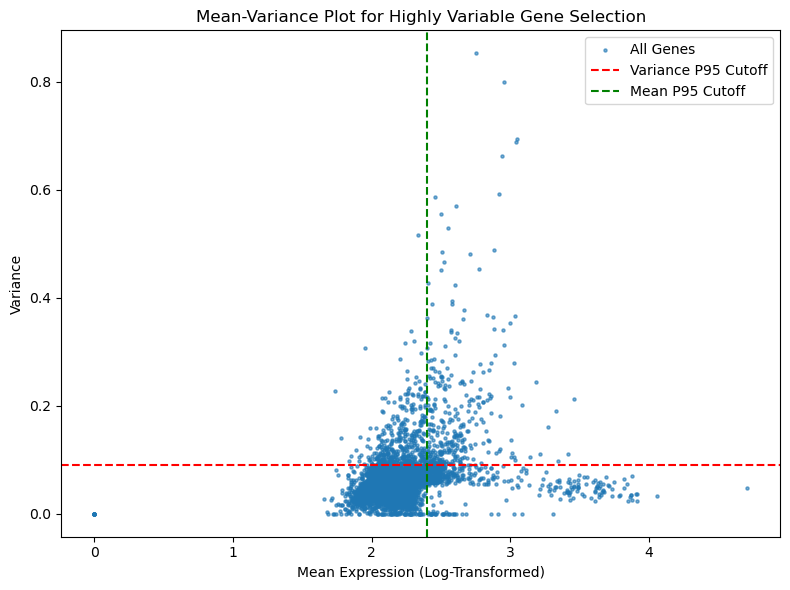


Default Mean Cutoff (P95): 2.4027
Default Variance Cutoff (P95): 0.0901


In [15]:
def calculate_hvg_metrics(data: pd.DataFrame):
    """Calculates non-zero mean and variance for each gene."""
    
    # Create a mask for non-zero values
    non_zero_mask = data > 0

    # Calculate variance and mean only where the gene is expressed
    # This replaces all original zeros with NaN
    non_zero_data = data.mask(~non_zero_mask)

    # Convert the masked DataFrame to a standard NumPy array to avoid SparseTypeError
    data_array = non_zero_data.values 

    # Use numpy.nanvar and numpy.nanmean to calculate statistics, which handles NaNs
    # Wrap results in a pandas Series to keep the gene names (columns) and fill NaNs with 0
    gene_variance = pd.Series(np.nanvar(data_array, axis=0), index=data.columns).fillna(0)
    gene_mean = pd.Series(np.nanmean(data_array, axis=0), index=data.columns).fillna(0)
    # --- END FIX ---

    # Combine into a single DataFrame for easy plotting and percentile calculation
    hvg_df = pd.DataFrame({
        'mean': gene_mean,
        'variance': gene_variance
    })
    return hvg_df

hvg_metrics = calculate_hvg_metrics(logged_data)


P_MEAN = 95
P_VAR = 95
mean_cutoff = float(np.percentile(hvg_metrics['mean'], P_MEAN))
var_cutoff = float(np.percentile(hvg_metrics['variance'], P_VAR))


# --- Plot the Mean-Variance Relationship ---
fig, ax = plt.subplots(1, figsize=(8, 6))

# Scatter plot all genes
ax.scatter(hvg_metrics['mean'], hvg_metrics['variance'], s=5, alpha=0.6, label='All Genes')

# Highlight the cutoffs
ax.axhline(var_cutoff, color='red', linestyle='--', label=f'Variance P{P_VAR} Cutoff')
ax.axvline(mean_cutoff, color='green', linestyle='--', label=f'Mean P{P_MEAN} Cutoff')

ax.set_xlabel('Mean Expression (Log-Transformed)')
ax.set_ylabel('Variance')
ax.set_title('Mean-Variance Plot for Highly Variable Gene Selection')
ax.legend()
fig.tight_layout()
plt.show()

print(f"\nDefault Mean Cutoff (P{P_MEAN}): {mean_cutoff:.4f}")
print(f"Default Variance Cutoff (P{P_VAR}): {var_cutoff:.4f}")
